## Step 1: Install SAM-2
To start the fine-tuning process, we need to install the SAM-2 library, which is crucial for the Segment Anything Model (SAM2). This model is designed to handle various segmentation tasks effectively. The installation involves cloning the SAM-2 repository from GitHub and installing the necessary dependencies.

In [1]:
!git clone https://github.com/facebookresearch/segment-anything-2
%cd /content/segment-anything-2
!pip install -q -e .

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1057, done.
remote: Counting objects: 100% (465/465), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 1057 (delta 281), reused 294 (delta 259), pack-reused 592 (from 1)
Receiving objects: 100% (1057/1057), 121.74 MiB | 41.80 MiB/s, done.
Resolving deltas: 100% (382/382), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.9 MB/s eta 0:

## Step 2: Download SAM-2 checkpoints
For the fine-tuning process, we need to start with pre-trained SAM2 model weights. These weights, called "checkpoints," are the starting point for further training. The checkpoints have been trained on a wide range of images, and by fine-tuning them on our specific dataset, we can achieve better performance on our target tasks.

In [2]:
!wget -O sam2_hiera_tiny.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt"
!wget -O sam2_hiera_small.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt"
!wget -O sam2_hiera_base_plus.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt"
!wget -O sam2_hiera_large.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt"

--2024-12-16 01:25:35--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.238.176.126, 18.238.176.44, 18.238.176.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.238.176.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155906050 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2_hiera_tiny.pt’

sam2_hiera_tiny.pt  100%[===================>] 148.68M   131MB/s    in 1.1s    

2024-12-16 01:25:36 (131 MB/s) - ‘sam2_hiera_tiny.pt’ saved [155906050/155906050]

--2024-12-16 01:25:36--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.238.176.126, 18.238.176.44, 18.238.176.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.238.176.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184309650 (176M) [appl

## Step 3: Data preparation
With the dataset in place, the next step is to prepare it for training. This involves splitting the dataset into training and testing sets and creating data structures that can be fed into the SAM 2 model during fine-tuning.

In [14]:
%cd /content/segment-anything-2

import os
import pandas as pd
import cv2
import torch
import torch.nn.utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Path to the chest-ct-segmentation dataset folder
data_dir = "/content/data"
images_dir = os.path.join(data_dir, "images")
masks_dir = os.path.join(data_dir, "masks")

# Load the train.csv file
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))

# Split the data into two halves: one for training and one for testing
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Prepare the training data list
train_data = []
for index, row in train_df.iterrows():
   image_name = row['ImageId']
   mask_name = row['MaskId']

   # Append image and corresponding mask paths
   train_data.append({
       "image": os.path.join(images_dir, image_name),
       "annotation": os.path.join(masks_dir, mask_name)
   })

# Prepare the testing data list (if needed for inference or evaluation later)
test_data = []
for index, row in test_df.iterrows():
   image_name = row['ImageId']
   mask_name = row['MaskId']

   # Append image and corresponding mask paths
   test_data.append({
       "image": os.path.join(images_dir, image_name),
       "annotation": os.path.join(masks_dir, mask_name)
   })


/content/segment-anything-2


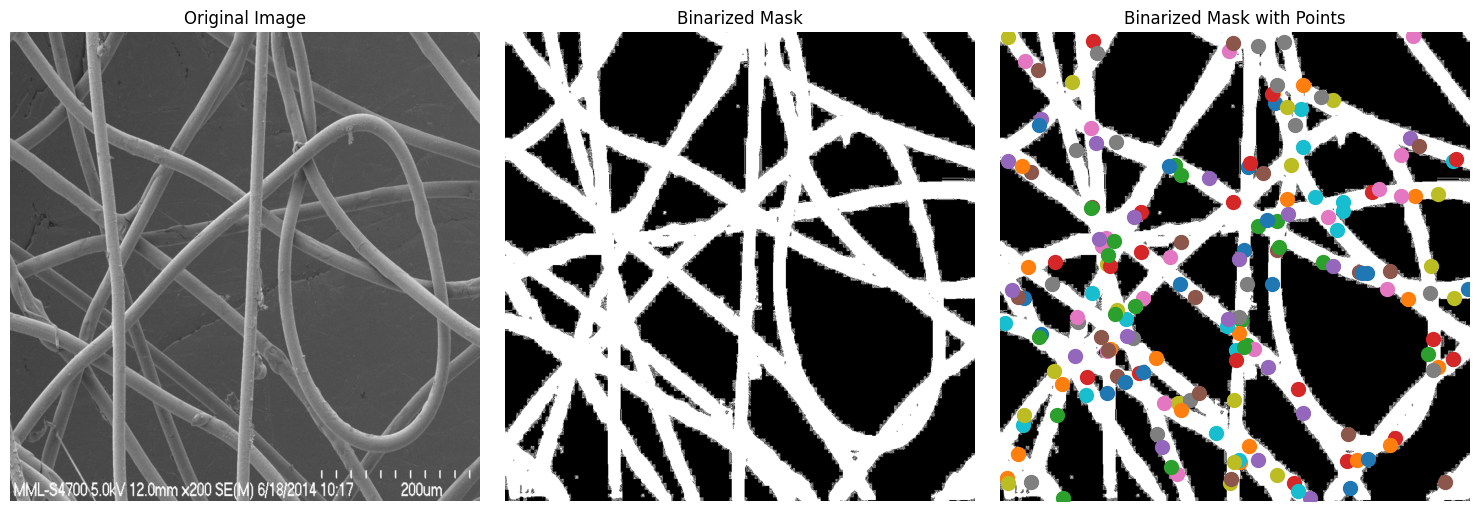

In [15]:
def read_batch(data, visualize_data=False):
    # Select a random entry
    ent = data[np.random.randint(len(data))]

    # Get full paths
    Img = cv2.imread(ent["image"])[..., ::-1]  # Convert BGR to RGB
    ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)  # Read annotation as grayscale

    if Img is None or ann_map is None:
        print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
        return None, None, None, 0

    # Resize image and mask
    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])  # Scaling factor
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

    ### Continuation of read_batch() ###

    # Initialize a single binary mask
    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)
    points = []

    # Get binary masks and combine them into a single mask
    inds = np.unique(ann_map)[1:]  # Skip the background (index 0)
    for ind in inds:
        mask = (ann_map == ind).astype(np.uint8)  # Create binary mask for each unique index
        binary_mask = np.maximum(binary_mask, mask)  # Combine with the existing binary mask

    # Erode the combined binary mask to avoid boundary points
    eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

    # Get all coordinates inside the eroded mask and choose a random point
    coords = np.argwhere(eroded_mask > 0)
    if len(coords) > 0:
        for _ in inds:  # Select as many points as there are unique labels
            yx = np.array(coords[np.random.randint(len(coords))])
            points.append([yx[1], yx[0]])

    points = np.array(points)

        ### Continuation of read_batch() ###

    if visualize_data:
        # Plotting the images and points
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(Img)
        plt.axis('off')

        # Segmentation Mask (binary_mask)
        plt.subplot(1, 3, 2)
        plt.title('Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')

        # Mask with Points in Different Colors
        plt.subplot(1, 3, 3)
        plt.title('Binarized Mask with Points')
        plt.imshow(binary_mask, cmap='gray')

        # Plot points in different colors
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100, label=f'Point {i+1}')  # Corrected to plot y, x order

        # plt.legend()
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    binary_mask = np.expand_dims(binary_mask, axis=-1)  # Now shape is (1024, 1024, 1)
    binary_mask = binary_mask.transpose((2, 0, 1))
    points = np.expand_dims(points, axis=1)

    # Return the image, binarized mask, points, and number of masks
    return Img, binary_mask, points, len(inds)

# Visualize the data
Img1, masks1, points1, num_masks = read_batch(train_data, visualize_data=True)




## Step 4: Model training

In [16]:
sam2_checkpoint = "sam2_hiera_large.pt"  # @param ["sam2_hiera_tiny.pt", "sam2_hiera_small.pt", "sam2_hiera_base_plus.pt", "sam2_hiera_large.pt"]
model_cfg = "sam2_hiera_l.yaml" # @param ["sam2_hiera_t.yaml", "sam2_hiera_s.yaml", "sam2_hiera_b+.yaml", "sam2_hiera_l.yaml"]

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)


In [17]:
# Train mask decoder.
predictor.model.sam_mask_decoder.train(True)

# Train prompt encoder.
predictor.model.sam_prompt_encoder.train(True)

# Configure optimizer.
optimizer=torch.optim.AdamW(params=predictor.model.parameters(), lr=5e-4, weight_decay=1e-4) #1e-5, weight_decay = 4e-5

# Mix precision.
scaler = torch.cuda.amp.GradScaler()

# No. of steps to train the model.
NO_OF_STEPS = 1200 # @param

# Fine-tuned model name.
FINE_TUNED_MODEL_NAME = "fine_tuned_sam2"


<ipython-input-17-743923213ff4>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [18]:
# Initialize scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5) # 500 , 250, gamma = 0.1
accumulation_steps = 4  # Number of steps to accumulate gradients before updating

for step in range(1, NO_OF_STEPS + 1):
   with torch.cuda.amp.autocast():
       image, mask, input_point, num_masks = read_batch(train_data, visualize_data=False)
       if image is None or mask is None or num_masks == 0:
           continue

       input_label = np.ones((num_masks, 1))
       if not isinstance(input_point, np.ndarray) or not isinstance(input_label, np.ndarray):
           continue

       if input_point.size == 0 or input_label.size == 0:
           continue

       predictor.set_image(image)
       mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
       if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0 or labels.shape[0] == 0:
           continue

       sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
           points=(unnorm_coords, labels), boxes=None, masks=None,
       )

       batched_mode = unnorm_coords.shape[0] > 1
       high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
       low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
           image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
           image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
           sparse_prompt_embeddings=sparse_embeddings,
           dense_prompt_embeddings=dense_embeddings,
           multimask_output=True,
           repeat_image=batched_mode,
           high_res_features=high_res_features,
       )
       prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

       gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
       prd_mask = torch.sigmoid(prd_masks[:, 0])
       seg_loss = (-gt_mask * torch.log(prd_mask + 1e-6) - (1 - gt_mask) * torch.log((1 - prd_mask) + 1e-6)).mean()

       inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
       iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
       score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
       loss = seg_loss + score_loss * 0.02  # Reduced IoU loss weight


       # Apply gradient accumulation
       loss = loss / accumulation_steps
       scaler.scale(loss).backward()

       # Clip gradients
       torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)

       if step % accumulation_steps == 0:
           scaler.step(optimizer)
           scaler.update()
           predictor.model.zero_grad()

       # Update scheduler
       scheduler.step()

       if step % 500 == 0:
           FINE_TUNED_MODEL = FINE_TUNED_MODEL_NAME + "_" + str(step) + ".torch"
           torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)

       if step == 1:
           mean_iou = 0

       mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())

       if step % 100 == 0:
           print("Step " + str(step) + ":\t", "Accuracy (IoU) = ", mean_iou)


<ipython-input-18-d2bc364401e3>:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Step 100:	 Accuracy (IoU) =  0.4685774462951636
Step 200:	 Accuracy (IoU) =  0.6854690315371752
Step 300:	 Accuracy (IoU) =  0.7677472325924627
Step 400:	 Accuracy (IoU) =  0.8175938431265198
Step 500:	 Accuracy (IoU) =  0.8209200931695004
Step 600:	 Accuracy (IoU) =  0.8352285415746797
Step 700:	 Accuracy (IoU) =  0.8287262665409418
Step 800:	 Accuracy (IoU) =  0.8274932210095873
Step 900:	 Accuracy (IoU) =  0.8438285376247615
Step 1000:	 Accuracy (IoU) =  0.8484715639939749
Step 1100:	 Accuracy (IoU) =  0.8438490634644009
Step 1200:	 Accuracy (IoU) =  0.8452671774197135


In [19]:
def read_image(image_path, mask_path):  # read and resize image and mask
   img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
   mask = cv2.imread(mask_path, 0)
   r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
   img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
   mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
   return img, mask

def get_points(mask, num_points):  # Sample points inside the input mask
   points = []
   coords = np.argwhere(mask > 0)
   for i in range(num_points):
       yx = np.array(coords[np.random.randint(len(coords))])
       points.append([[yx[1], yx[0]]])
   return np.array(points)

In [26]:
# Download the model
FINE_TUNED_MODEL_NAME = "/content/fine_tuned_sam2_final.torch"
torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL_NAME)
print(f"Final model weights saved to {FINE_TUNED_MODEL_NAME}")

Final model weights saved to /content/fine_tuned_sam2_final.torch


## Step 5: Visualizing results

<ipython-input-22-aa094fbf6f62>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))


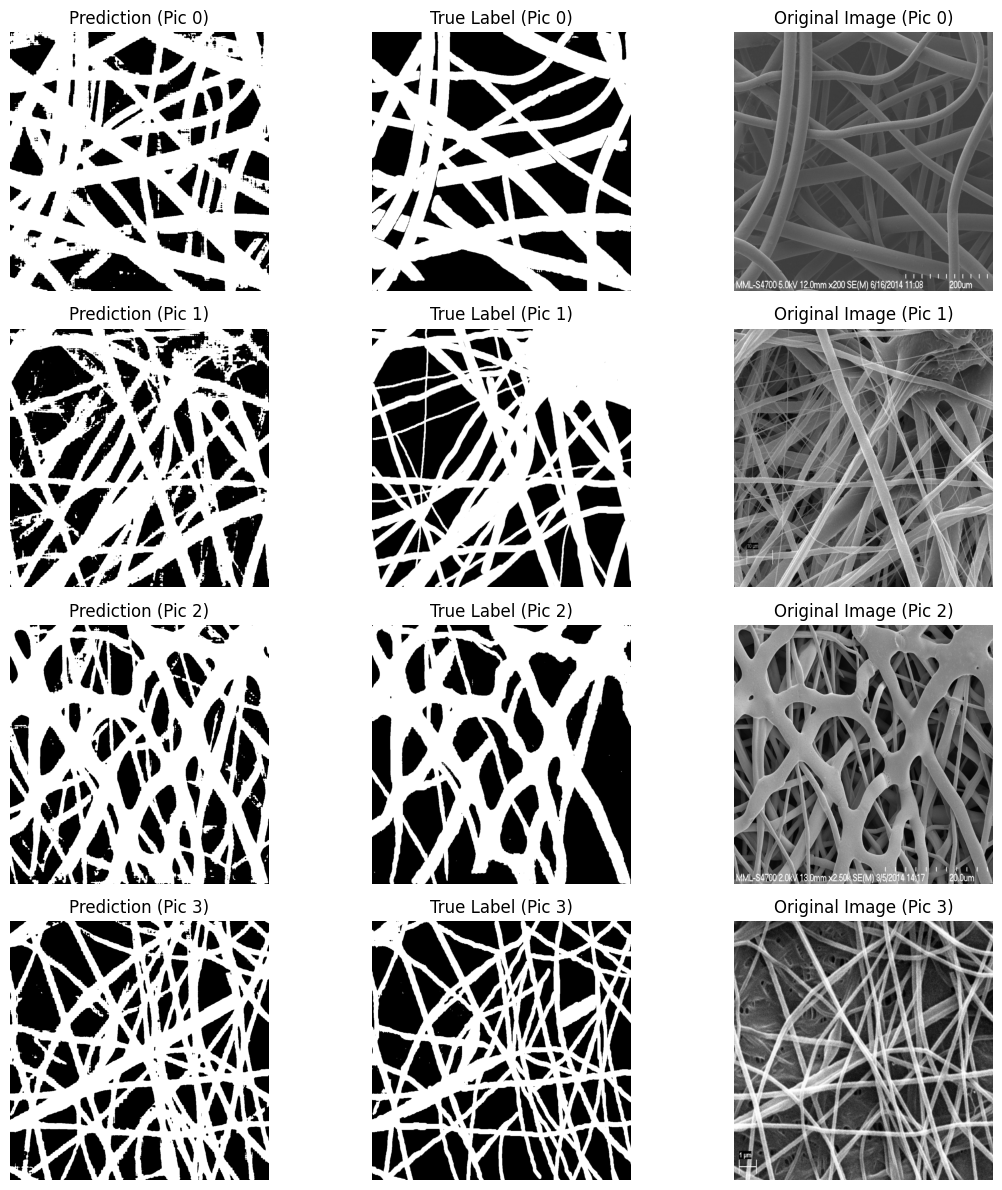

In [22]:
# Visualizing the results

import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# Define paths to test images and masks
test_images_dir = "/content/data/test_images"
test_masks_dir = "/content/data/test_masks"

# List all test images and masks
test_image_files = sorted([f for f in os.listdir(test_images_dir) if f.endswith(".jpg") or f.endswith(".png")])
test_mask_files = sorted([f for f in os.listdir(test_masks_dir) if f.endswith(".jpg") or f.endswith(".png")])

# Load the fine-tuned model (only once, outside the loop for efficiency)
FINE_TUNED_MODEL_WEIGHTS = "fine_tuned_sam2_1000.torch"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

# Number of images to display in a grid
num_images_to_display = 4

# Create a figure for grid visualization
fig, axes = plt.subplots(num_images_to_display, 3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.2, wspace=0.05)

for idx, (image_file, mask_file) in enumerate(zip(test_image_files, test_mask_files)):
    if idx >= num_images_to_display:  # Show only the specified number of images
        break

    # Paths to the current image and mask
    image_path = os.path.join(test_images_dir, image_file)
    mask_path = os.path.join(test_masks_dir, mask_file)

    # Load the image and mask
    image = np.array(Image.open(image_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"))  # Convert mask to grayscale

    # Generate random points for the input
    num_samples = 30  # Number of points per segment to sample
    input_points = get_points(mask, num_samples)

    # Perform inference and predict masks
    with torch.no_grad():
        predictor.set_image(image)
        masks, scores, logits = predictor.predict(
            point_coords=input_points,
            point_labels=np.ones([input_points.shape[0], 1])
        )

    # Process the predicted masks and sort by scores
    np_masks = np.array(masks[:, 0])
    np_scores = scores[:, 0]
    sorted_masks = np_masks[np.argsort(np_scores)][::-1]

    # Initialize segmentation map and occupancy mask
    seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
    occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

    # Combine masks to create the final segmentation map
    for i in range(sorted_masks.shape[0]):
        mask_pred = sorted_masks[i]
        if (mask_pred * occupancy_mask).sum() / mask_pred.sum() > 0.15:
            continue

        mask_bool = mask_pred.astype(bool)
        mask_bool[occupancy_mask] = False
        seg_map[mask_bool] = 1  # Use single mask for visualization
        occupancy_mask[mask_bool] = True

    # Visualization: Prediction, True Mask, Original Image
    axes[idx, 0].imshow(seg_map, cmap='gray')
    axes[idx, 0].set_title(f'Prediction (Pic {idx})')
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(mask, cmap='gray')
    axes[idx, 1].set_title(f'True Label (Pic {idx})')
    axes[idx, 1].axis('off')

    axes[idx, 2].imshow(image)
    axes[idx, 2].set_title(f'Original Image (Pic {idx})')
    axes[idx, 2].axis('off')

# Display the grid
plt.tight_layout()
plt.show()

